# Introduction: Predicting Island Friendly Cars and Spy Drones with XGBoost
_**Using Gradient Boosted Trees to Predict Cars that low impact to the Island's fragile ecosystem**_

_**DIY Note:**_ We will be using this same notebook for the DIY portion of the lab by making small changes to the files and referenced frames.



---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Compile](#Compile)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
  1. [Relative cost of errors](#Relative-cost-of-errors)
1. [Extensions](#Extensions)

---

## Background

_This notebook has been adapted from an [AWS blog post](https://aws.amazon.com/blogs/ai/predicting-customer-churn-with-amazon-machine-learning/)_

Island ecosystems are fragile and to reduce the impact that some automobiles have we need a way to predict which automobiles are island friendly.  By giving island citizens the ability to input their automobile data we can give them the opportunity to steer away from automobiles that may not be healthy to the environment, cause crowding, and deplete resources. This notebook describes using machine learning (ML) for the automated identification of island friendly vehicles. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

---

## Setup

_This notebook was created and tested on a `ml.m4.xlarge` notebook instance._

Let's start by updating the required packages i.e. SageMaker Python SDK, `pandas` and `numpy`, and specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with the appropriate full IAM role arn string(s).

#### Code Cell 1 ####

In [3]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install sagemaker pandas numpy --upgrade


  Using cached sagemaker-2.165.0-py2.py3-none-any.whl
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached attrs-23.1.0-py3-none-any.whl (61 kB)
  Using cached boto3-1.26.155-py3-none-any.whl (135 kB)
  Using cached PyYAML-6.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (596 kB)
  Using cached botocore-1.29.155-py3-none-any.whl (10.9 MB)
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.3
ERROR: Cannot uninstall 'PyYAML'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


#### Code Cell 2 ####

In [4]:
import sagemaker
import boto3
import re
from sagemaker import get_execution_role

sess = sagemaker.Session()

# Define lab bucket
lab_account = boto3.client('sts').get_caller_identity()['Account']
bucket = f"spy-drones-lab-{lab_account}"
print("default-bucket: " + bucket)
prefix = "lab/xgboost-island-friendly"

# Define IAM role
role = get_execution_role()
print("Default IAM role: " + role)

default-bucket: spy-drones-lab-550964951749
Default IAM role: arn:aws:iam::550964951749:role/sagemaker_studio_role


Next, we'll import the Python libraries we'll need for the remainder of the exercise.

#### Code Cell 3 ####

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

---
## Data

The data for this model comes from [University of California Irvine](https://archive.ics.uci.edu/ml/datasets/automobile/) Machine Learning Repository and originally used for the purposes of assigning insurance risk scores to vehicles.  We have modified the data set slightly for our purposes.  We can use this historical information to construct an ML model to predict island friendly vehicles using a process called training. After training the model, we can pass the profile information of an arbitrary car (the same profile information that we used to train the model) to the model, and have the model predict whether this vehicle is island friendly or not.  Of course, we expect the model to make mistakes–after all, predicting the future is tricky business! But I’ll also show how to deal with prediction errors.

Let's download and read that dataset in now:

**DIY Note:** Comment out the line for download of DroneFlights.csv and uncomment the line for DroneFlights.csv 

#### Code Cell 4 ####

In [6]:
## For DIY section comment out the below line
#!aws s3 cp s3://{bucket}/IslandAutos.csv ./
    
## For DIY section uncomment the below line
!aws s3 cp s3://{bucket}/DroneFlights.csv ./
    

download: s3://spy-drones-lab-550964951749/DroneFlights.csv to ./DroneFlights.csv


### Working with missing data

The data scientist that provided the data did some clean-up and any previously empty or erroneous values have been populated with a question mark (?).  We will import the data using the na_values parameter that references a list of known missing values.  

As you work through the data and see other types of missing values, you can add them to the list below:

**DIY Note:** In the below code cell change `IslandAutos.csv` file to `DroneFlights.csv` 

#### Code Cell 5 ####

In [7]:
# Make a list of missing value types
missing_values = ["?"]

ml_data = pd.read_csv("./DroneFlights.csv", na_values = missing_values)
pd.set_option("display.max_columns", 500)

#display a summary view
ml_data

,spy?,drone-id,flight-duration,transponder,max-altitude,max-speed
0,0,7875,10,1.0,6,2
1,0,7996,11,1.0,4,3
2,0,8333,19,1.0,5,4
3,0,7490,6,1.0,7,1
4,0,5797,5,1.0,2,5
...,...,...,...,...,...,...
199,0,50,2,NaN,21,100
200,0,60,4,NaN,16,150
201,0,70,8,NaN,27,100
202,0,80,10,NaN,11,400


### Dealing with missing data

The imported data frame above has 205 rows. The below code creates a new dataframe and prints out all rows with a least one attribute marked as __NaN__.  As you can see only a few rows have empty values.

**DIY Note:** Some of the earlier drone models (those with id less then 100) had bad transponders that malfunctioned with speeds exceeding safety standards.  We will clean those up in the next few steps/

#### Code Cell 6 ####

In [ ]:
#New Data Frame that displays all rows with at least one attribute marked NaN
missing_df = ml_data[ml_data.isna().any(axis=1)]
missing_df


#### Code Cell 7 ####

In [8]:
## Fill the missing data and or delete bad data.
## The next three lines need to be commnented out for the DIY portion of the lab.  

#mean = ml_data['price'].mean()                         #Comment out this line for DIY portion of lab
#print("The mean vehicle price is: " + str(mean))       #Comment out this line for DIY portion of lab
#ml_data['price'].fillna(mean)                          #Comment out this line for DIY portion of lab

#Drop any rows which still have missing values
ml_data.dropna(axis=0, how='any',inplace=True)

#Summary view - Notice the # of data values was reduced after dropping data.
ml_data


,spy?,drone-id,flight-duration,transponder,max-altitude,max-speed
0,0,7875,10,1.0,6,2
1,0,7996,11,1.0,4,3
2,0,8333,19,1.0,5,4
3,0,7490,6,1.0,7,1
4,0,5797,5,1.0,2,5
...,...,...,...,...,...,...
190,1,3943,28,1.0,21,25
191,0,6532,19,0.0,8,5
192,0,4410,35,1.0,11,1
193,1,5646,27,0.0,23,3


### Data Features ###

Now that we have done a first pass at cleaning up the data lets review more details about it.  

By modern standards, it’s a relatively small dataset, with less than 200 records, where each record has 16 attributes to describe the profile of a vehicle. The attributes are:

- `make`: The automobile manufacturer; for example, audi or dodge.
- `fuel-type`: Diesel or Gas.
- `aspiration`: turbo vs standard.
- `num-of-doors`: Number of doors (Two or Four).
- `body-style`: wagon, sedan, hatchback, etc. 
- `drive-wheels`: front wheel drive (fwd), four wheel drive (4wd) or rear-wheel drive (rwd)
- `engine-location`: Front or Back.
- `curb-weight`: continuous from 1488 to 4066
- `engine-type`: dohc, dohcv, l, ohc, ohcf, ohcv, rotor.
- `num-of-cylinders`: eight, five, four, six, three, twelve, two.
- `horsepower`: continuous from 48 to 288.
- `peak-rpm`: continuous from 4150 to 6600.
- `city-mpg`: continuous from 13 to 49.
- `highway-mpg`: continuous from 16 to 54.
- `price`: continuous from 5118 to 45400.
- `island-friendly?`: 0 = no; 1 = yes.


The last attribute, `island-friendly?`, is known as the target attribute–the attribute that we want the ML model to predict.  Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

Let's begin exploring the data:


**DIY Note:** The target attribute for the DroneFLights data set is `spy?` 

Other fields in the DroneFlights data set are:
- `drone-id`: Randomly generated id for drones.  Older drones have lower id numbers.
- `flight-duration`: Friendly drones normally do not fly for more than 20 minutes. 
- `transponder`: On (1) or Off (0); Older spy drones did not have transponders; but newere ones can fake a transponder signal.
- `max-altitide`: Spy drones fly at higher altitudes. 
- `max-speed`: Spy drones display significantly higher speeds since when spotted they need to make a quick escape.


#### Code Cell 8 ####

,spy?,drone-id,flight-duration,transponder,max-altitude,max-speed
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.507692,5352.902564,22.866667,0.620513,14.866667,11.984615
std,0.501228,2621.933149,10.520607,0.486508,8.885449,6.778131
min,0.000000,555.000000,1.000000,0.000000,1.000000,1.000000
25%,0.000000,3330.000000,16.000000,0.000000,8.000000,6.000000
50%,1.000000,5382.000000,23.000000,1.000000,14.000000,11.000000
75%,1.000000,7559.000000,31.500000,1.000000,23.000000,17.500000
max,1.000000,12001.000000,40.000000,1.000000,30.000000,25.000000


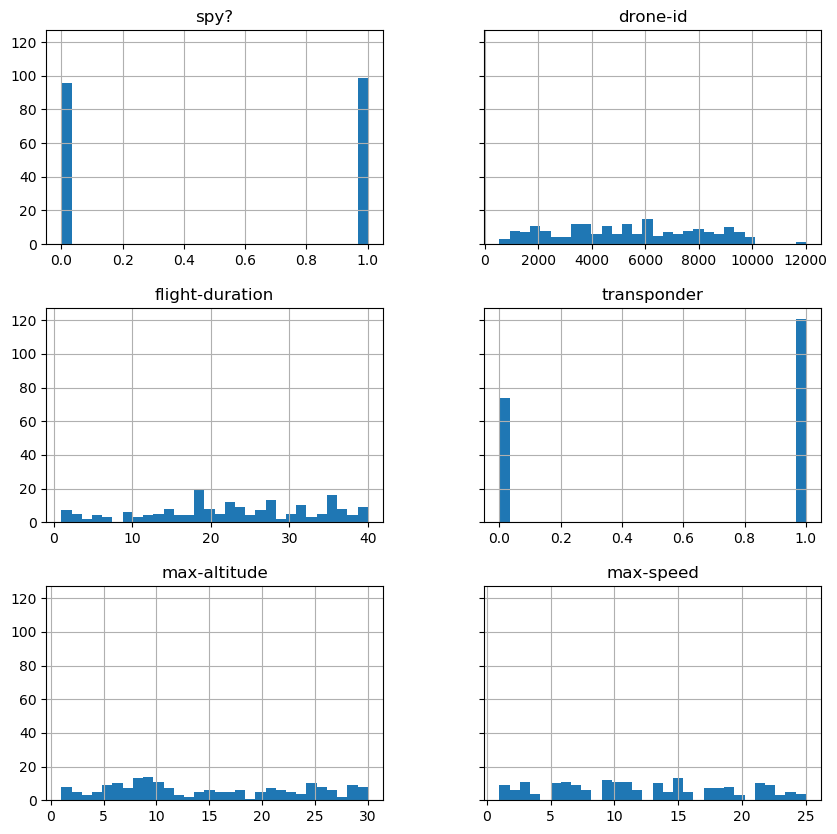

In [9]:
for column in ml_data.select_dtypes(include=["object"]).columns:
    display(pd.crosstab(index=ml_data[column], columns="% observations", normalize="columns"))

# Histograms for each numeric features
display(ml_data.describe())
%matplotlib inline
hist = ml_data.hist(bins=30, sharey=True, figsize=(10, 10))

We can see immediately that:
- `city-mpg` is quite quite evenly distributed
- `highway-mpg` statistics are very similar to city-mpg.  So we will drop highway-mpg as it seems redundant.
- Most of the numeric features are surprisingly nicely distributed, with many showing bell-like `gaussianity`.  `peak-rpm` being a notable exception, so we will drop that feature from the data as well.


**DIY Note:** We can see that `drone-id` is evenly distributed and there is no correlation between it and a drone being friendly or a spy.  So we will drop that feature from our data set.

#### Code Cell 9 ####

In [ ]:
# DIY Note:  You can skip running of the next two lines by commenting them out. 

#ml_data = ml_data.drop("highway-mpg", axis=1)
#ml_data = ml_data.drop("peak-rpm", axis=1)

In [ ]:
# DIY Note:  Uncomment the next line to drop the feature `drone-id` from the data set. 
ml_data = ml_data.drop("drone-id", axis=1)

Next let's look at the relationship between each of the features and our target variable.

**DIY Note:** In the below code cells carefully review and replace reference `island-friendly?` with `spy?`

#### Code Cell 10 ####

flight-duration


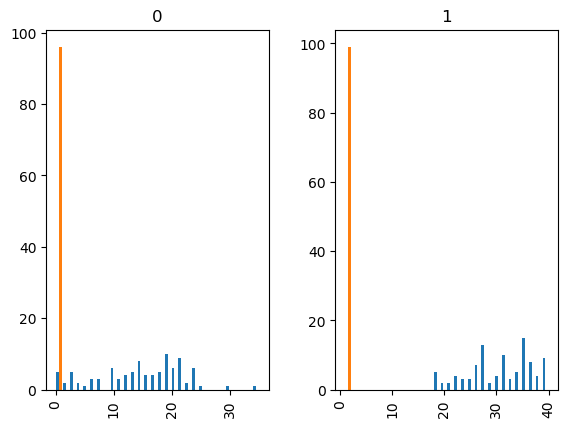

transponder


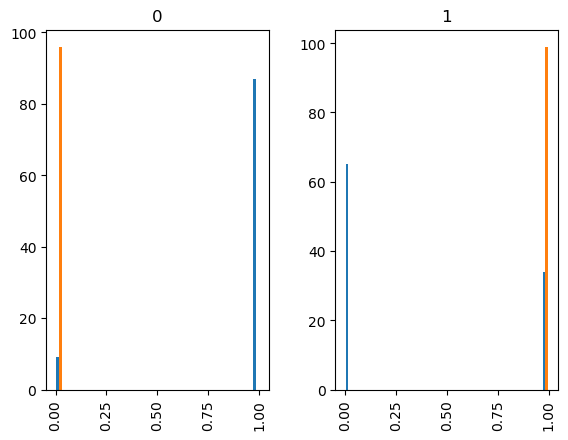

max-altitude


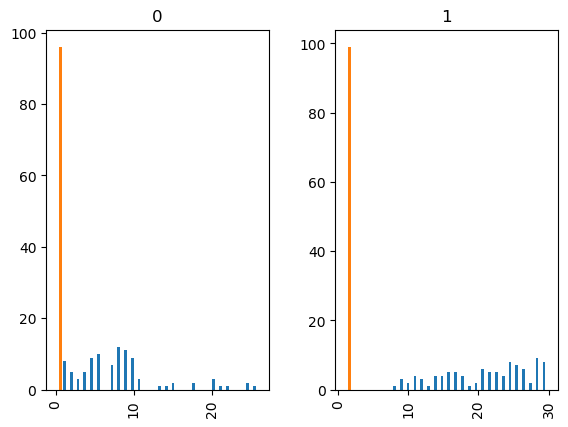

max-speed


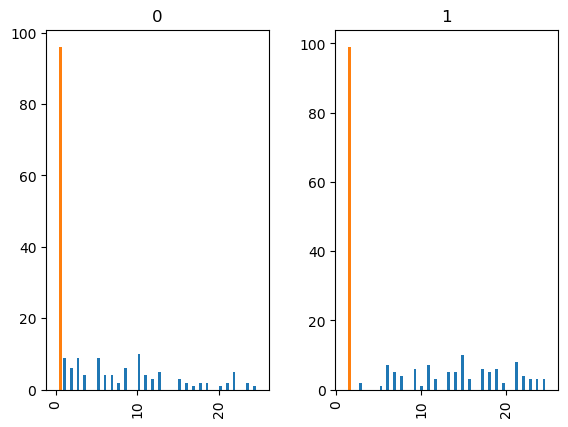

In [13]:
for column in ml_data.select_dtypes(include=["object"]).columns:
    if column != "spy?":
        display(pd.crosstab(index=ml_data[column], columns=ml_data["spy?"], normalize="columns"))

for column in ml_data.select_dtypes(exclude=["object"]).columns:
    if column != "spy?":
        print(column)
        hist = ml_data[[column, "spy?"]].hist(by="spy?", bins=30)
        plt.show()

#### Code Cell 11 ####

,spy?,flight-duration,transponder,max-altitude,max-speed
spy?,1.000000,0.768521,-0.579844,0.736339,0.396792
flight-duration,0.768521,1.000000,-0.403708,0.689187,0.357926
transponder,-0.579844,-0.403708,1.000000,-0.423149,-0.301902
max-altitude,0.736339,0.689187,-0.423149,1.000000,0.341202
max-speed,0.396792,0.357926,-0.301902,0.341202,1.000000


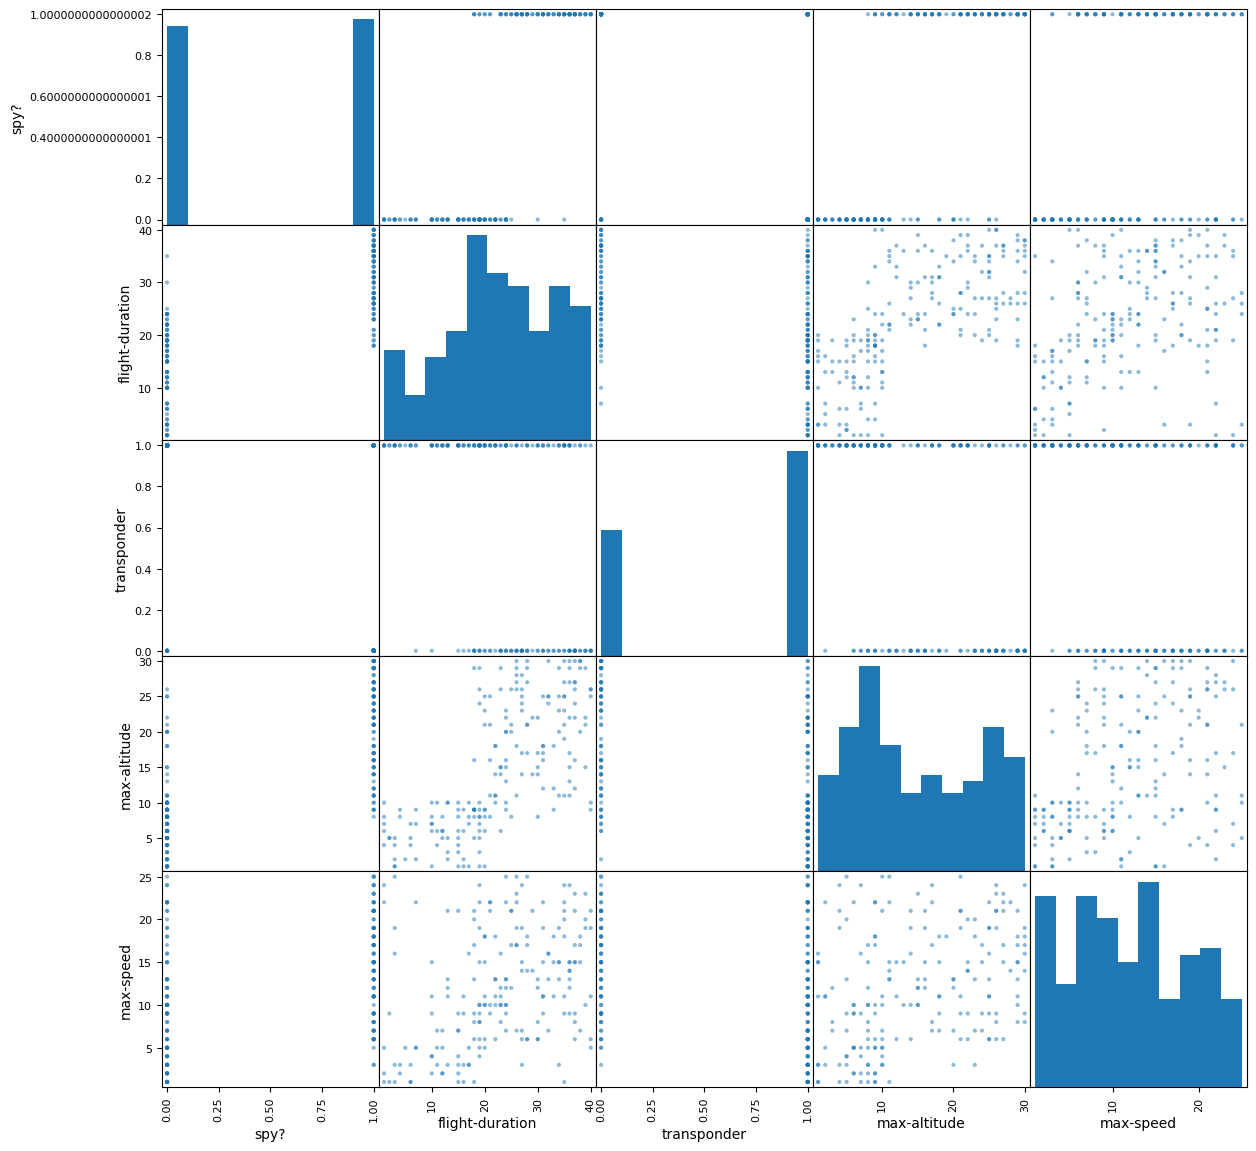

In [14]:
display(ml_data.corr())
pd.plotting.scatter_matrix(ml_data, figsize=(14, 14))
plt.show()

#### Code Cell 12 ####

In [15]:
# Final dimensions of the dataset
ml_data.shape

(195, 5)

Now that we've cleaned up our dataset, let's determine which algorithm to use.  As mentioned above, there appears to be some variables where both high and low (but not intermediate) values are predictive of non island-friendly vehicles. In order to accommodate this in an algorithm like linear regression, we'd need to generate polynomial (or bucketed) terms.  Instead, let's attempt to model this problem using gradient boosted trees.  Amazon SageMaker provides an XGBoost container that we can use to train in a managed, distributed setting, and then host as a real-time prediction endpoint.  XGBoost uses gradient boosted trees which naturally account for non-linear relationships between features and the target variable, as well as accommodating complex interactions between features.

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format.  For this example, we'll stick with CSV.  It should:
- Have the predictor variable in the first column
- Not have a header row

But first, let's convert our categorical features into numeric features.

#### Code Cell 13 ####

In [17]:
model_data = pd.get_dummies(ml_data)

model_data

,spy?,flight-duration,transponder,max-altitude,max-speed
0,0,10,1.0,6,2
1,0,11,1.0,4,3
2,0,19,1.0,5,4
3,0,6,1.0,7,1
4,0,5,1.0,2,5
...,...,...,...,...,...
190,1,28,1.0,21,25
191,0,19,0.0,8,5
192,0,35,1.0,11,1
193,1,27,0.0,23,3


And now let's split the data into training, validation, and test sets.  This will help prevent us from over-fitting the model, and allow us to test the model's accuracy on data it hasn't already seen.

#### Code Cell 14 ####

In [18]:
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(model_data)), int(0.9 * len(model_data))],
)
train_data.to_csv("train.csv", header=False, index=False)
validation_data.to_csv("validation.csv", header=False, index=False)

Now we'll upload these files to S3.

#### Code Cell 15 ####

In [19]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train/train.csv")
).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation/validation.csv")
).upload_file("validation.csv")

---
## Train

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.

#### Code Cell 16 ####

In [20]:
container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "latest")
display(container)

'811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest'

Then, because we're training with the CSV file format, we'll create `TrainingInput`s that our training function can use as a pointer to the files in S3.

#### Code Cell 17 ####

In [21]:
s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="csv"
)

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between numerous shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to over-fitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyper-parameters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

#### Code Cell 18 ####

In [22]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)
xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    silent=0,
    objective="binary:logistic",
    num_round=100,
)

xgb.fit({"train": s3_input_train, "validation": s3_input_validation})

INFO:sagemaker:Creating training-job with name: xgboost-2023-06-17-16-37-00-670


2023-06-17 16:37:01 Starting - Starting the training job...
2023-06-17 16:37:37 Starting - Preparing the instances for training.........
2023-06-17 16:38:55 Downloading - Downloading input data...
2023-06-17 16:39:26 Training - Downloading the training image...
2023-06-17 16:39:56 Training - Training image download completed. Training in progress..Arguments: train
[2023-06-17:16:40:11:INFO] Running standalone xgboost training.
[2023-06-17:16:40:11:INFO] File size need to be processed in the node: 0.0mb. Available memory size in the node: 8598.59mb
[2023-06-17:16:40:11:INFO] Determined delimiter of CSV input is ','
[16:40:11] S3DistributionType set as FullyReplicated
[16:40:11] 136x4 matrix with 544 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-06-17:16:40:11:INFO] Determined delimiter of CSV input is ','
[16:40:11] S3DistributionType set as FullyReplicated
[16:40:11] 39x4 matrix with 156 entries loaded from /opt/ml/input/data/validation?format

---
## Host

Now that we've trained the algorithm, let's create a model and deploy it to a hosted endpoint.

#### Code Cell 19 ####

In [23]:
xgb_predictor = xgb.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=CSVSerializer()
)

INFO:sagemaker:Creating model with name: xgboost-2023-06-17-16-40-54-619
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-06-17-16-40-54-619
INFO:sagemaker:Creating endpoint with name xgboost-2023-06-17-16-40-54-619


-----!

### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making a `http` POST request.  But first, we'll need to set up serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

#### Code Cell 20 ####

In [25]:
def predict(data, rows=50):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ""
    for array in split_array:
        predictions = ",".join([predictions, xgb_predictor.predict(array).decode("utf-8")])

    return np.fromstring(predictions[1:], sep=",")


predictions = predict(test_data.to_numpy()[:, 1:])

#### Code Cell 21 ####

In [26]:
print(test_data)
print(predictions)

     spy?  flight-duration  transponder  max-altitude  max-speed
112     1               36          1.0            22         14
51      0               15          1.0             8          7
147     1               25          0.0            21         21
44      0               15          1.0             4         21
171     1               31          1.0            25         11
83      1               40          0.0            26         21
93      0               18          1.0             9          6
111     1               28          1.0            17         17
164     1               23          0.0            26          8
91      1               35          1.0            21         21
35      0               13          1.0             2         11
59      0               15          0.0             6          9
89      1               39          0.0            15         23
194     1               34          1.0            20          3
67      1               3

There are many ways to compare the performance of a machine learning model, but let's start by simply by comparing actual to predicted values.  In this case, we're simply predicting whether the vehicle is island friendly (`1`) or not (`0`), which produces a simple confusion matrix.

#### Code Cell 22 ####

In [27]:
pd.crosstab(
    index=test_data.iloc[:, 0],
    columns=np.round(predictions),
    rownames=["actual"],
    colnames=["predictions"],
)

predictions,0.0,1.0
actual,,
0,7,0
1,0,13


_Note, due to randomized elements of the algorithm, your results may differ slightly._

Of the 20 vehicles, we've correctly predicted 19 of them (true positives). And, we incorrectly predicted 1 vehicle to be island-friendly but ended up not being so which is known as a false positive.  There are no false negatives in our testing.  

An important point here is that because of the `np.round()` function above we are using a simple threshold (or cutoff) of 0.5.  Our predictions from `xgboost` come out as continuous values between 0 and 1, and we force them into the binary classes that we began with.  
To get a rough intuition here, let's look at the continuous values of our predictions.

#### Code Cell 23 ####

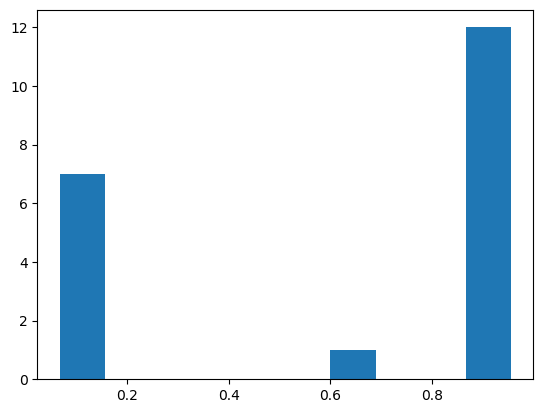

In [28]:
plt.hist(predictions)
plt.show()

### (Optional) Clean-up

If you're ready to be done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

Remove the comment (#) before running the code.

In [ ]:
#xgb_predictor.delete_endpoint()